In [1]:
import re
import time
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
from datetime import datetime
from scipy import stats

%matplotlib inline
plt.style.use('bmh')
warnings.filterwarnings('ignore')

# I. Data Acquisition

In [2]:
train_df = pd.read_csv('data/Data_Train.csv')
test_df = pd.read_csv('data/Data_Test.csv')
train_df.head()

,Unique_ID,Name,Genre,Country,Song_Name,Timestamp,Views,Comments,Likes,Popularity,Followers
0,413890,Hardstyle,danceedm,AU,N-Vitral presents BOMBSQUAD - Poison Spitter (...,2018-03-30 15:24:45.000000,14017,4,499,97,119563
1,249453,Dj Aladdin,danceedm,AU,Dj Aladdin - Old School Hip Hop Quick Mix,2016-06-20 05:58:52.000000,1918,17,49,17,2141
2,681116,Maxximize On Air,danceedm,AU,Maxximize On Air - Mixed by Blasterjaxx - Epis...,2015-05-08 17:45:59.000000,9668,11,312,91,22248
3,387253,GR6 EXPLODE,rbsoul,AU,MC Yago - Tenho Compromisso (DJ R7),2017-06-08 23:50:03.000000,113036,2,"2,400",76,393655
4,1428029,Tritonal,danceedm,AU,Escape (feat. Steph Jones),2016-09-17 20:50:19.000000,110024,81,"3,031",699,201030


## 1.0 Examine the data quality
There is no missing data. Note that "Likes" and "Popularity" are in string format.

In [3]:
train_df.info()
print('_'*40)
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 78458 entries, 0 to 78457
Data columns (total 11 columns):
Unique_ID     78458 non-null int64
Name          78458 non-null object
Genre         78458 non-null object
Country       78458 non-null object
Song_Name     78457 non-null object
Timestamp     78458 non-null object
Views         78458 non-null int64
Comments      78458 non-null int64
Likes         78458 non-null object
Popularity    78458 non-null object
Followers     78458 non-null int64
dtypes: int64(4), object(7)
memory usage: 6.6+ MB
________________________________________
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19615 entries, 0 to 19614
Data columns (total 10 columns):
Unique_ID     19615 non-null int64
Name          19615 non-null object
Genre         19615 non-null object
Country       19615 non-null object
Song_Name     19615 non-null object
Timestamp     19615 non-null object
Comments      19615 non-null int64
Likes         19615 non-null object
Popularity   

## 1.1 Convert "Likes" and "Popularity" to numeric data type

In [4]:
def conv_numeric_feature(feature):
    feature = feature.replace(',', '')
    vals = [int(val) for val in re.findall('\d+', feature)]
    if len(vals) == 1:
        return vals[0] * 1000 if 'K' in feature else vals[0] 
    elif len(vals) == 2:
        if '.' in feature:
            value = vals[0] + 0.1 * vals[1]
            if 'K' in feature:
                value = value * 1000
            return value
        return None
    else:
        return None

In [5]:
train_df['Likes'] = train_df['Likes'].apply(lambda likes: conv_numeric_feature(likes))
train_df['Popularity'] = train_df['Popularity'].apply(lambda popularity: conv_numeric_feature(popularity))
test_df['Likes'] = test_df['Likes'].apply(lambda likes: conv_numeric_feature(likes))
test_df['Popularity'] = test_df['Popularity'].apply(lambda popularity: conv_numeric_feature(popularity))

In [6]:
train_info_df = pd.DataFrame(train_df.dtypes)
train_info_df['MissingVal'] = train_df.isnull().sum()
train_info_df['NUnique'] = train_df.nunique()
train_info_df['Count'] = train_df.count()
train_info_df = train_info_df.rename(columns = {0: 'DataType'})
train_info_df

,DataType,MissingVal,NUnique,Count
Unique_ID,int64,0,78458,78458
Name,object,0,1209,78458
Genre,object,0,21,78458
Country,object,0,1,78458
Song_Name,object,1,78457,78457
Timestamp,object,0,68187,78458
Views,int64,0,53964,78458
Comments,int64,0,2152,78458
Likes,float64,0,9211,78458
Popularity,float64,0,5719,78458


# II. Exploratory Analysis
The following features are screened for analysis and to be used for prediction.
<ul>
    <li>Qualitative feature: Genre, Release date, which will be transformed to year and month</li>
    <li>Quantitative features: Views, Comments, Likes, Popularity, Followers, Timestamp</li>
</ul>

## 2.1 Univariate Analysis
### 2.1.1 Genre

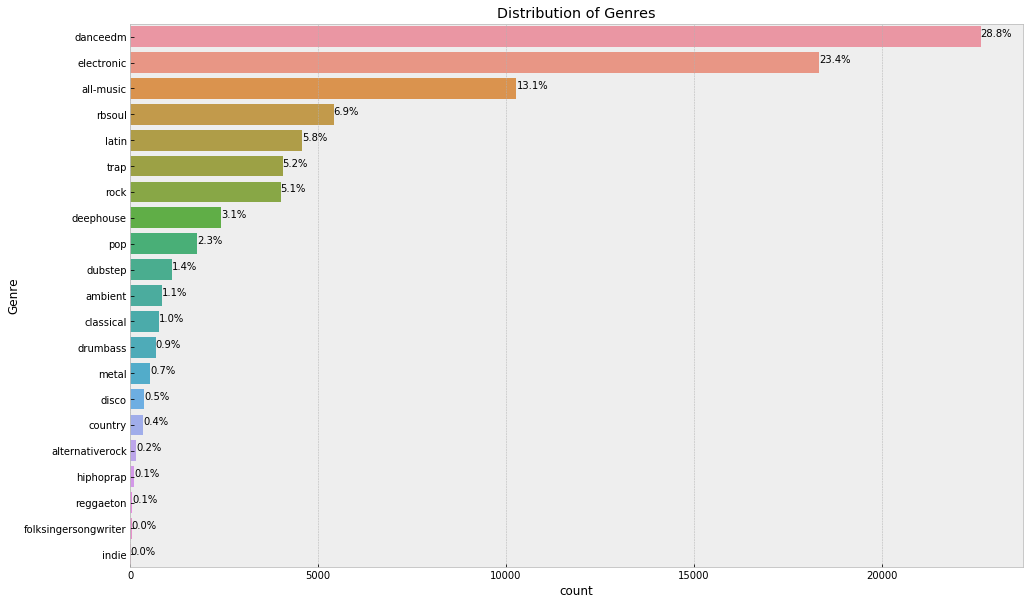

In [7]:
fig = plt.figure(figsize=(16, 10))
ax = sns.countplot(y='Genre', data=train_df, order=train_df['Genre'].value_counts().index)
plt.title('Distribution of Genres')

total = len(train_df['Genre'])
for p in ax.patches:
    percentage = '{:.1f}%'.format(100 * p.get_width()/total)
    x = p.get_x() + p.get_width() + 0.02
    y = p.get_y() + p.get_height()/2
    ax.annotate(percentage, (x, y))

plt.show()

### 2.1.2 Release year and month

In [8]:
def extract_year_month(ts_str):
    ts = datetime.strptime(ts_str, '%Y-%m-%d %H:%M:%S.%f')
    return ts.year, ts.month

start_time = time.time()
lambda_expr = lambda ts_str: pd.Series(extract_year_month(ts_str))
train_df[['Release_Year', 'Release_Month']] = train_df['Timestamp'].apply(lambda_expr)
print("Elapsed time: %s seconds" % round(time.time() - start_time, 4))

Elapsed time: 19.1537 seconds


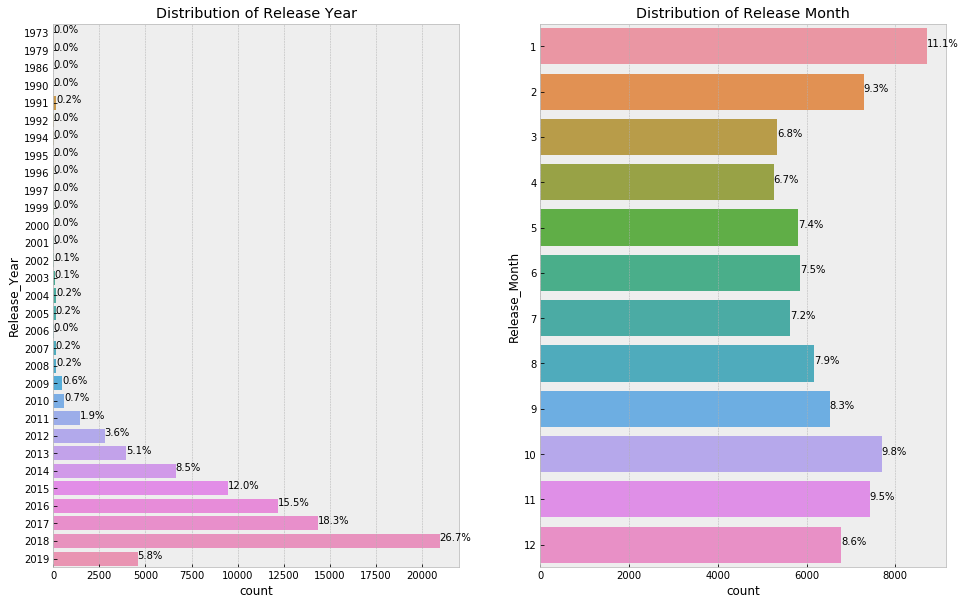

In [9]:
f, ax = plt.subplots(1, 2, figsize=(16, 10))
sns.countplot(y='Release_Year', data=train_df, ax=ax[0])
ax[0].set_title('Distribution of Release Year')

total = len(train_df['Release_Year'])
for p in ax[0].patches:
    percentage = '{:.1f}%'.format(100 * p.get_width()/total)
    x = p.get_x() + p.get_width() + 0.02
    y = p.get_y() + p.get_height()/2
    ax[0].annotate(percentage, (x, y))

sns.countplot(y='Release_Month', data=train_df, ax=ax[1])
ax[1].set_title('Distribution of Release Month')

total = len(train_df['Release_Year'])
for p in ax[1].patches:
    percentage = '{:.1f}%'.format(100 * p.get_width()/total)
    x = p.get_x() + p.get_width() + 0.02
    y = p.get_y() + p.get_height()/2
    ax[1].annotate(percentage, (x, y))

plt.show()

### 2.1.3 Social counts

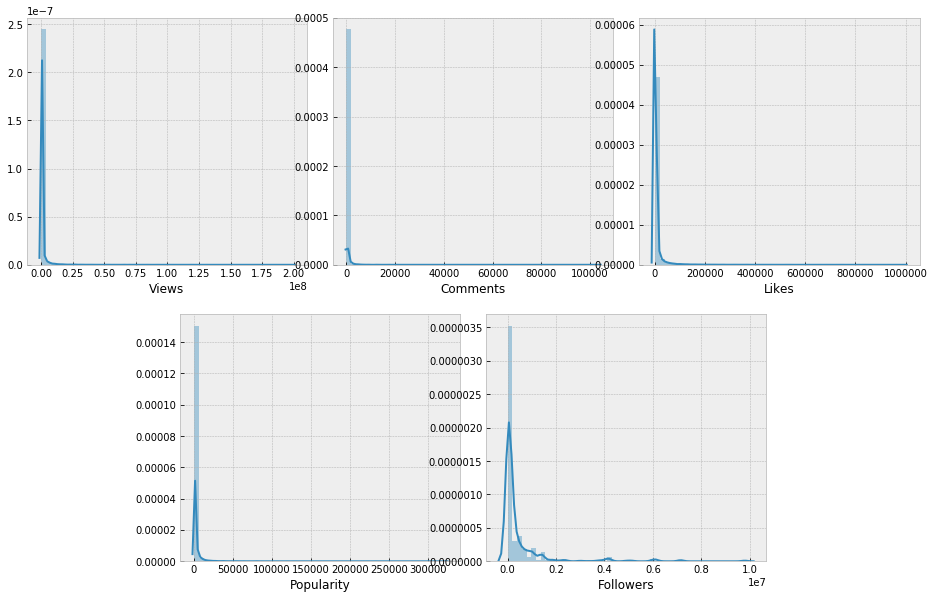

In [10]:
fig = plt.figure(figsize=(16, 10))
ax1 = plt.subplot2grid(shape=(2,6), loc=(0,0), colspan=2)
ax2 = plt.subplot2grid((2,6), (0,2), colspan=2)
ax3 = plt.subplot2grid((2,6), (0,4), colspan=2)
ax4 = plt.subplot2grid((2,6), (1,1), colspan=2)
ax5 = plt.subplot2grid((2,6), (1,3), colspan=2)

sns.distplot(train_df['Views'], kde=True, ax=ax1)
sns.distplot(train_df['Comments'], kde=True, ax=ax2)
sns.distplot(train_df['Likes'], kde=True, ax=ax3)
sns.distplot(train_df['Popularity'], kde=True, ax=ax4)
sns.distplot(train_df['Followers'], kde=True, ax=ax5)

Perform Box-Cox transformation to reduce the skewness of features. Note that Box-Cox transformation is more effective than Log transformation in this case.

In [11]:
train_df['BC_Views'] = stats.boxcox(train_df['Views'] + 1)[0]
train_df['BC_Comments'] = stats.boxcox(train_df['Comments'] + 1)[0]
train_df['BC_Likes'] = stats.boxcox(train_df['Likes'] + 1)[0]
train_df['BC_Popularity'] = stats.boxcox(train_df['Popularity'] + 1)[0]
train_df['BC_Followers'] = stats.boxcox(train_df['Followers'] + 1)[0]

# Compare skewness coefficient of Views before and after transformation
print(train_df['Views'].skew())
print(train_df['BC_Views'].skew())
train_df.head()

21.426370782553978
0.05545480119519009


,Unique_ID,Name,Genre,Country,Song_Name,Timestamp,Views,Comments,Likes,Popularity,Followers,Release_Year,Release_Month,BC_Views,BC_Comments,BC_Likes,BC_Popularity,BC_Followers
0,413890,Hardstyle,danceedm,AU,N-Vitral presents BOMBSQUAD - Poison Spitter (...,2018-03-30 15:24:45.000000,14017,4,499.0,97.0,119563,2018,3,12.526992,1.503982,7.038090,4.683402,20.989877
1,249453,Dj Aladdin,danceedm,AU,Dj Aladdin - Old School Hip Hop Quick Mix,2016-06-20 05:58:52.000000,1918,17,49.0,17.0,2141,2016,6,9.355383,2.562027,4.228329,2.929286,11.139083
2,681116,Maxximize On Air,danceedm,AU,Maxximize On Air - Mixed by Blasterjaxx - Epis...,2015-05-08 17:45:59.000000,9668,11,312.0,91.0,22248,2015,5,11.908196,2.239518,6.445757,4.617511,16.425116
3,387253,GR6 EXPLODE,rbsoul,AU,MC Yago - Tenho Compromisso (DJ R7),2017-06-08 23:50:03.000000,113036,2,2400.0,76.0,393655,2017,6,16.247662,1.048771,9.103484,4.432092,24.679608
4,1428029,Tritonal,danceedm,AU,Escape (feat. Steph Jones),2016-09-17 20:50:19.000000,110024,81,3031.0,699.0,201030,2016,9,16.196768,3.674061,9.421646,6.753267,22.549205


In [12]:
train_df.describe()

,Unique_ID,Views,Comments,Likes,Popularity,Followers,Release_Year,Release_Month,BC_Views,BC_Comments,BC_Likes,BC_Popularity,BC_Followers
count,7.845800e+04,7.845800e+04,78458.000000,78458.000000,78458.000000,7.845800e+04,78458.000000,78458.000000,78458.000000,78458.000000,78458.000000,78458.000000,78458.000000
mean,7.451701e+05,5.469686e+05,115.270973,8033.394921,920.825524,4.787663e+05,2015.931951,6.523962,13.764202,2.233757,7.320797,4.440429,20.019440
std,4.805507e+05,3.883085e+06,724.614868,39926.707912,4810.374304,1.168120e+06,2.770140,3.622101,4.611816,1.574941,3.226836,2.506113,6.520806
min,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,1.000000e+00,1973.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.715711
25%,3.149512e+05,6.216500e+03,1.000000,129.000000,13.000000,1.770000e+04,2015.000000,3.000000,11.188664,0.673080,5.363566,2.671473,15.857094
50%,6.618655e+05,2.538650e+04,12.000000,664.000000,87.000000,8.768200e+04,2017.000000,7.000000,13.542888,2.304070,7.404089,4.571173,20.094089
75%,1.176618e+06,1.201342e+05,61.000000,2843.000000,405.000000,3.936550e+05,2018.000000,10.000000,16.362705,3.479676,9.334075,6.176027,24.679608
max,1.570012e+06,1.994050e+08,104082.000000,992000.000000,324000.000000,9.789123e+06,2019.000000,12.000000,33.650993,7.351441,18.327035,13.461670,36.901850


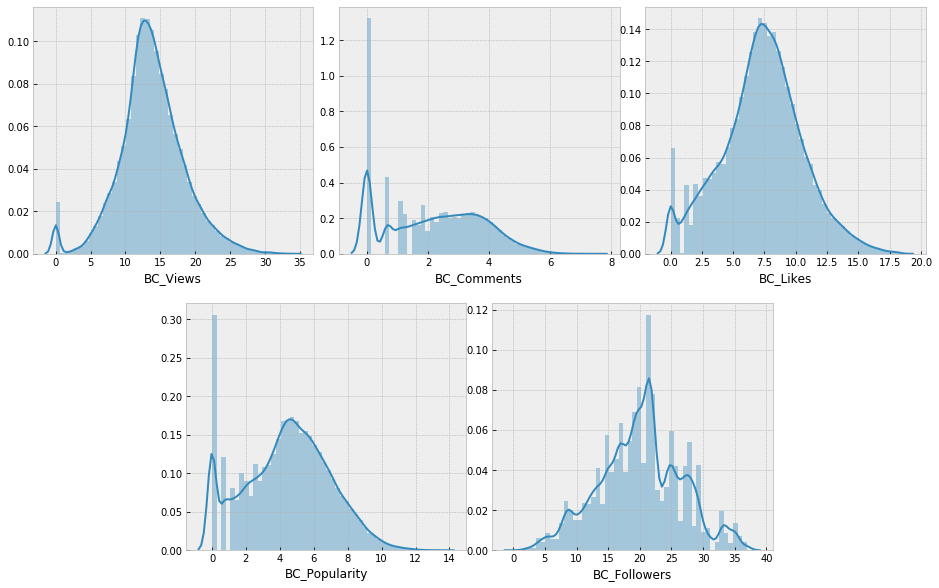

In [13]:
fig = plt.figure(figsize=(16, 10))
ax1 = plt.subplot2grid(shape=(2,6), loc=(0,0), colspan=2)
ax2 = plt.subplot2grid((2,6), (0,2), colspan=2)
ax3 = plt.subplot2grid((2,6), (0,4), colspan=2)
ax4 = plt.subplot2grid((2,6), (1,1), colspan=2)
ax5 = plt.subplot2grid((2,6), (1,3), colspan=2)

sns.distplot(train_df['BC_Views'], kde=True, ax=ax1)
sns.distplot(train_df['BC_Comments'], kde=True, ax=ax2)
sns.distplot(train_df['BC_Likes'], kde=True, ax=ax3)
sns.distplot(train_df['BC_Popularity'], kde=True, ax=ax4)
sns.distplot(train_df['BC_Followers'], kde=True, ax=ax5)

## 2.2 Bivariate Analysis

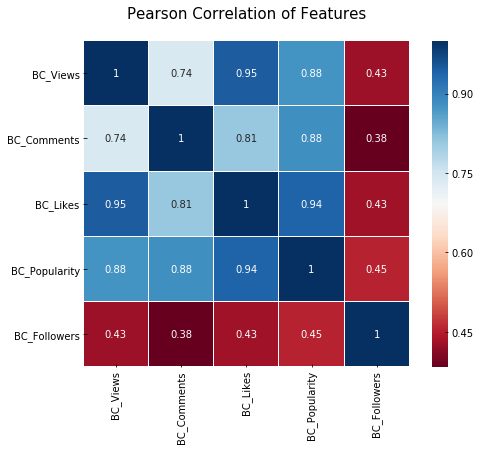

In [14]:
transformed_features = ['BC_Views', 'BC_Comments', 'BC_Likes', 'BC_Popularity', 'BC_Followers']
quan_train_df = train_df[transformed_features]

colormap = plt.cm.RdBu
plt.figure(figsize=(8, 6))
plt.title('Pearson Correlation of Features', y=1.05, size=15)
sns.heatmap(quan_train_df.astype(float).corr(), linewidths=0.1, vmax=1.0,
            square=True, cmap=colormap, linecolor='white', annot=True)

Elapsed time: 5.1549 seconds


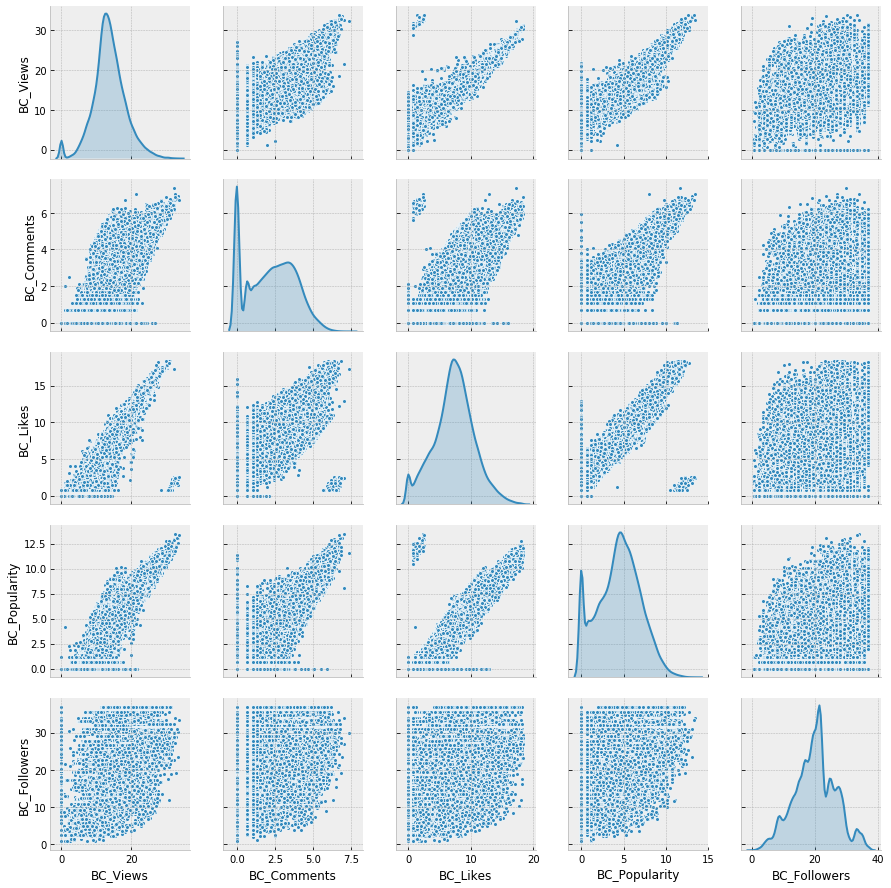

In [15]:
start_time = time.time()
sns.pairplot(quan_train_df, diag_kind="kde", plot_kws={"s": 15})
print("Elapsed time: %s seconds" % round(time.time() - start_time, 4))

### 2.2.1 BC_Views vs. Genres

Index(['indie', 'hiphoprap', 'classical', 'all-music', 'reggaeton', 'dubstep',
       'rbsoul', 'drumbass', 'disco', 'danceedm', 'electronic',
       'alternativerock', 'country', 'metal', 'deephouse', 'trap', 'latin',
       'ambient', 'pop', 'rock', 'folksingersongwriter'],
      dtype='object', name='Genre')


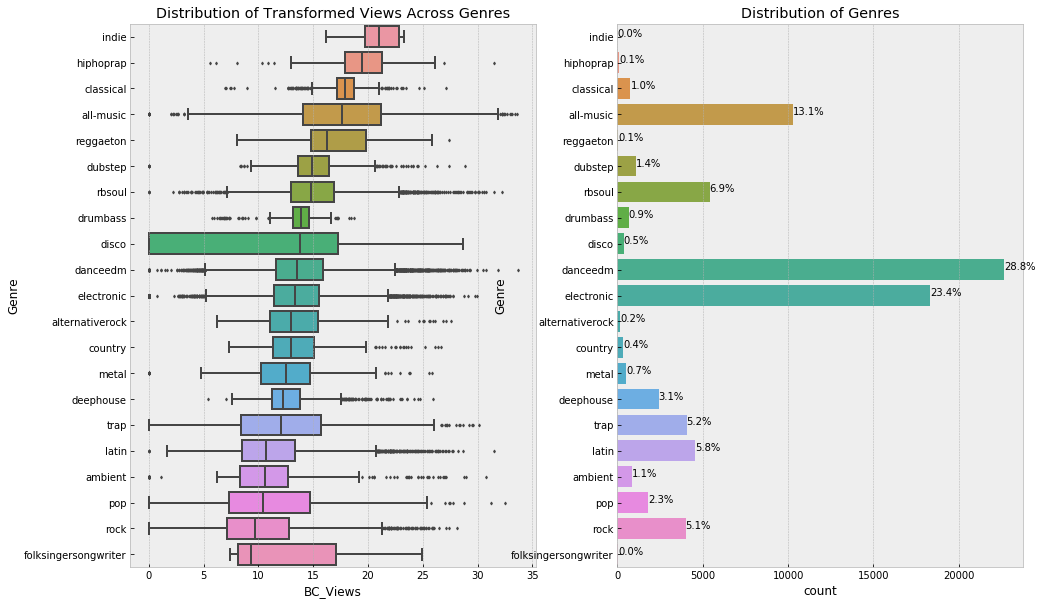

In [40]:
genres_sorted_by_views = train_df.groupby('Genre')[['BC_Views']].median().sort_values(by=['BC_Views'],
                                                                                      ascending=False).index
print(genres_sorted_by_views)

f, ax = plt.subplots(1, 2, figsize=(16, 10))
sns.catplot(x="BC_Views", y="Genre", kind="box", data=train_df,
                order=genres_sorted_by_views, fliersize=2, ax=ax[0]);
ax[0].set_title('Distribution of Transformed Views Across Genres')

sns.countplot(y='Genre', data=train_df, order=genres_sorted_by_views, ax=ax[1])
total = len(train_df['Genre'])
for p in ax[1].patches:
    percentage = '{:.1f}%'.format(100 * p.get_width()/total)
    x = p.get_x() + p.get_width() + 0.02
    y = p.get_y() + p.get_height()/2
    ax[1].annotate(percentage, (x, y))

ax[1].set_title('Distribution of Genres')
plt.close(2)
plt.show()

### 2.2.2 BC_Views vs. Release Year & Month

In [44]:
# train_df['Release_Year'] = train_df['Release_Year'].apply(str)
# sns.catplot(x="BC_Views", y="Release_Year", kind="box", data=train_df,
#             fliersize=2,)

train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 78458 entries, 0 to 78457
Data columns (total 18 columns):
Unique_ID        78458 non-null int64
Name             78458 non-null object
Genre            78458 non-null object
Country          78458 non-null object
Song_Name        78457 non-null object
Timestamp        78458 non-null object
Views            78458 non-null int64
Comments         78458 non-null int64
Likes            78458 non-null float64
Popularity       78458 non-null float64
Followers        78458 non-null int64
Release_Year     78458 non-null object
Release_Month    78458 non-null int64
BC_Views         78458 non-null float64
BC_Comments      78458 non-null float64
BC_Likes         78458 non-null float64
BC_Popularity    78458 non-null float64
BC_Followers     78458 non-null float64
dtypes: float64(7), int64(5), object(6)
memory usage: 10.8+ MB


# III. Feature Engineering
Genres will be split into 4 groups by their frequency and distribution of view counts. One purpose of grouping the genres is to overcome the class imbalance. The resulting 4 genre groups are as follows.
<ul>
    <li>indie, hiphoprap, classical, all-music, reggaeton, dubstep, rbsoul, drumbass, disco</li>
    <li>danceedm</li>
    <li>electronic</li>
    <li>alternativerock, country, metal, deephouse, trap, latin, ambient, pop, rock, folksingersongwriter</li>
</ul>